# STAND fitting notebook

Written by Kyle Huston, implements model described in:

Garrido, P. F., Brocos, P., Amigo, A., García-Río, L., Gracia-Fadrique, J., & Piñeiro, Á. (2016). STAND: Surface Tension for Aggregation Number Determination. _Langmuir_, 32(16), 3917–3925. http://doi.org/10.1021/acs.langmuir.6b00477

Here, instead of simulated annealing I use differential evolution from scipy to find the most likely parameters, and I take a Bayesian approach to uncertainty, using pymc to sample the posterior distribution.

In all of the following steps, you simply have to execute the code, except for step 2, in which you input the experimental data.

1. Initialize functions by excecuting first code cell.
2. Input total concentration and surface tension data by defining `ct_data` and `st_data`.
3. Find maximum likelihood parameters.
4. Define statistical model.
5. Run inferece.
6. Plot MCMC traces, pairwise correlations, and posterior distributions.
7. Plot posterior predictive distribution.

**Note:** Keep in mind that the $\Delta\mu^o$ is dependent on the units of concentration. To compare with micellization free energies from other models (e.g. Blankschtein et al. $g_\text{mic}$), a unit-dependent conversion term must be added to $\Delta\mu^o$. Also note that to compare with the values in Table 1 of the STAND publication (Garrido et al. 2016), $4RT$ must be subtracted from the $\Delta\mu^o$ values computed here.

## 1. Initialize functions

In [1]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set(style='ticks', palette='Set2', font_scale=1.5)
sns.despine()
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from numpy import log, exp
from copy import copy
from scipy.optimize import fsolve

def lnK_from_deltamu(deltamu, T, N):
    # R in units of kJ/mol-K
    R = 8.3144598e-3
    return -deltamu*N/(R*T)

def target_func(cf, ct, N, K):
    return -ct + cf + N*K*cf**N

def cf_from_ct(ct, deltamu, N):
    lnK = lnK_from_deltamu(deltamu, T, N)
    return np.array([fsolve(target_func, x, args=(x, N, exp(lnK)))[0] for x in ct])

def cf_from_ct_data(deltamu, lnN):
    return cf_from_ct(ct_data, deltamu, exp(lnN))

def ct_from_cf(cf, lnK, n):
    return cf + n*exp(lnK)*cf**n

def pressure_from_cf(cf, beta, Gmax, T):
    """
    Parameters
    ----------
    Gmax : float
        maximum coverage in micromoles per square meter
    
    T : float
        temperature in Kelvin
    
    beta : float
        liters per mole
    
    cf : float
        moles per liter
    """
    R = 8.3144598e-3
    return Gmax * R * T * log(1 + beta * cf)

## 2. Input data

Input concentrations in moles per liter (M) and surface tensions in millinewtons per meter (mN/m).

Example data below:

In [2]:
# c10e4 at water/air
# DOI: 10.1021/la00047a018

ct_data_c10e4 = [0.000110136, 0.000273687, 0.000431371, 0.000555476, 0.000606863,
                 0.000663104, 0.000724666, 0.000802018, 0.001115306]
st_data_c10e4 = [45.54203128, 37.5435193, 33.12688827, 30.91832939, 30.08272752,
                 29.6645007, 29.66364891, 29.54342543, 29.54026165]
T_c10e4 = 298.15

# c12e6 at water/air
# DOI: 10.1021/la00047a018

ct_data_c12e6 = [1.11e-5, 3.38e-5, 4.46e-5, 5.60e-5, 6.12e-5, 6.69e-5,
                 7.31e-5, 8.30e-5, 1.12e-4]
st_data_c12e6 = [45.92180606, 39.05422225, 36.66654498, 34.99485452,
                 34.33812767, 33.74102583, 33.38242401, 33.38120717, 33.08016174]
T_c12e6 = 298.15

# c8g1 at water/air
# DOI: 10.1021/acs.langmuir.6b00477

ct_data_c8g1_298K = [0.0009940828402366878, 0.00314792899408284, 0.0062130177514792915, 0.009360946745562131,
                   0.012674556213017753, 0.015573964497041421, 0.01822485207100592, 0.020213017751479295,
                   0.022284023668639057, 0.02402366863905326, 0.02650887573964498, 0.02882840236686391,
                   0.032473372781065095, 0.038189349112426045, 0.04249704142011835, 0.04945562130177516,
                   0.0534319526627219, 0.05889940828402368]

st_data_c8g1_298K = [60.0915750915751, 50.787545787545795, 44.41391941391942, 40.31135531135532,
                       37.60073260073261, 35.25641025641026, 33.791208791208796, 32.91208791208792,
                       31.959706959706963, 31.37362637362638, 31.080586080586087, 31.007326007326014,
                       31.007326007326014, 30.86080586080587, 30.86080586080587, 30.787545787545795,
                       30.787545787545795, 30.787545787545795]

T_c8g1_298K = 298.

# tween 65 at water/air
# DOI: 10.1002/jps.2600630136

ct_data_t65 = [0.000336808, 0.000150468, 6.19238e-5, 3.90917e-5, 2.39025e-5,
               1.86913e-5, 3.89607e-6, 1.56249e-5, 7.99077e-6]
st_data_t65 = [40.95861797, 41.00786172, 41.23050768, 41.79551499,
               43.52706864, 44.43604174, 57.3635769, 46.51082067, 50.96509741]

T_t65 = 298.

# tween 80 at water/air
# DOI: 10.1002/jps.2600630136

ct_data_t80 = [0.000379271, 7.69483e-5, 3.79372e-5, 2.31654e-5,
               1.30315e-5, 9.69433e-6, 7.71303e-6, 2.37515e-6, 3.81731e-6]
st_data_t80 = [45.36377437, 45.41894218, 45.3378566, 45.42795169,
               45.77784154, 45.99604446, 47.9416048, 55.46664322, 52.52571721]

T_t80 = 298.

ct_data_t80_ow1 = [0.00007374544506906946, 0.00017255132995218746, 0.000025683677970934697,
                   0.000007364259770238503, 7.742503425186337e-7, 0.0000018873110868746412,
                   0.0006511146774706802, 0.006805353621055349]
st_data_t80_ow1 = [7.209688643455216, 2.6232967427660654, 15.873796215233348,
                   25.911733674545985, 41.01241385502952, 35.610478820122566,
                   1.773632343367673, 1.7644285810492235]

#T_t80_ow1 = ?? does the paper even say?
T_t80_ow1 = 298.

# STAND website example
# http://smmb.usc.es/stand/stand.php

ct_data_example = [0.000963, 0.003230, 0.006238, 0.009380, 0.012570, 0.015740, 0.018410,
                   0.020250, 0.022550, 0.024030, 0.026620, 0.028970, 0.032940, 0.038830,
                   0.043320, 0.050650, 0.054420, 0.059990] 
st_data_example = [62.24, 53.20, 47.26, 43.75, 41.04, 38.85, 37.35, 36.12,
                   35.24, 34.55, 33.33, 32.82, 32.20, 32.15, 32.06, 32.01, 31.99, 31.94] 

T_example = 298

Specify the data to be used in calculations and analysis below

In [3]:
ct_data = ct_data_t80_ow1
st_data = st_data_t80_ow1
T = T_t80_ow1

## 3. Find maximum likelihood parameters

Use differential evolution to try finding the global maximum likelihood parameters

**Note:** Differential evolution is a probabilistic solver (as is simulated annealing). This is not guaranteed to globally best fit on the first try. If the fit appears very bad, then try running this again.

Parameter names:
- $\Delta\mu^o$ : deltamu 
- $N$ : N
- $\beta$ : beta
- $\Gamma_{\text{max}}$ : Gmax

In [4]:
from scipy.optimize import differential_evolution

def MAP_objective(x):
    deltamu, lnN, lnbeta, lnGmax = x
    N = exp(lnN)
    beta = exp(lnbeta)
    Gmax = exp(lnGmax)
    cf_data = cf_from_ct(ct_data, deltamu, N)
    return np.sum((72.-pressure_from_cf(cf_data, beta, Gmax, T)-st_data)**2.)

result = differential_evolution(MAP_objective, bounds=[[-80, 0], [0, 9], [0, 30], [-10, 10]])
deltamu_MAP, lnN_MAP, lnbeta_MAP, lnGmax_MAP = result['x']
N_MAP = exp(lnN_MAP)
beta_MAP = exp(lnbeta_MAP)
Gmax_MAP = exp(lnGmax_MAP)

Plot maximum likelihood parameterized model with data

<IPython.core.display.Javascript object>


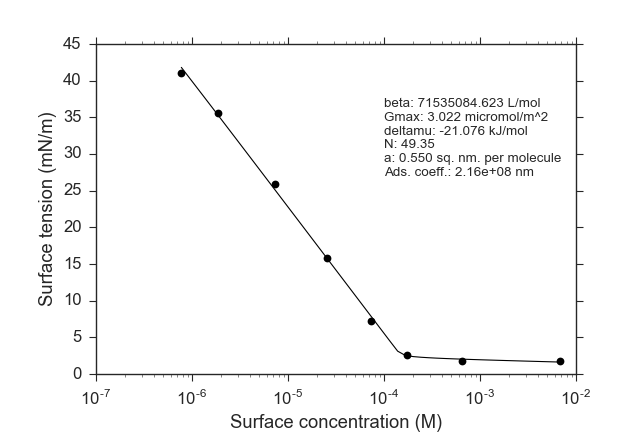

In [5]:
%matplotlib notebook

sns.set(style='ticks', palette='Set2', font_scale=1.5)

fig = plt.figure()

ct_sample = np.logspace(np.log10(min(ct_data)), np.log10(max(ct_data)))
cf_sample = cf_from_ct(ct_sample, deltamu_MAP, N_MAP)
plt.plot(ct_sample, 72.-pressure_from_cf(cf_sample, beta_MAP, Gmax_MAP, T),
         'k', linewidth='1.')

plt.plot(ct_data, st_data, 'ko')
plt.xlabel('Surface concentration (M)')
plt.ylabel('Surface tension (mN/m)')
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)
plt.text(0.6, 0.6, 'beta: {beta:.3f} L/mol\n'
                    'Gmax: {Gmax:.3f} micromol/m^2\n'
                    'deltamu: {deltamu:.3f} kJ/mol\n'
                    'N: {N:.2f}\n'
                    'a: {a:.3f} sq. nm. per molecule\n'
                    'Ads. coeff.: {adscoeff:.3g} nm'.format(
        beta=beta_MAP, Gmax=Gmax_MAP, deltamu=deltamu_MAP, N=N_MAP,
        a=1./(Gmax_MAP*0.6022141), adscoeff=Gmax_MAP*beta_MAP),
         transform=fig.transFigure)

plt.xscale('log')

## 4a. Define statistical model

All unknown parameters are given uniform priors. Note that a uniform prior spanning orders of magnitude will heavily bias the top orders of magnitude. For this reason, in some cases the parameters used are _log_ values, because their uncertainty spans many orders of magnitude.

Standard deviation of observations is included as a hyperparameter `lnsigma`, and this will fluctuate along with the other parameters during MCMC. Some tweaking is required if the user wants to use their own averaged data and measurement noise estimates.

If you find that the upper and lower bounds are too restrictive, then adjust them. Also change the neat surface tension in the function `st` if needed.

In [6]:
import pymc

deltamu = pymc.Uniform('deltamu', lower=-80, upper=0, value=deltamu_MAP)
lnN =     pymc.Uniform('lnN', lower=0, upper=9, value=lnN_MAP)
lnbeta =  pymc.Uniform('lnbeta', lower=0, upper=30, value=lnbeta_MAP)
lnGmax =  pymc.Uniform('lnGmax', lower=-10, upper=10, value=lnGmax_MAP)
lnsigma = pymc.Uniform('lnsigma', lower=-7, upper=4)

@pymc.deterministic()
def st(deltamu=deltamu, lnN=lnN, lnbeta=lnbeta, lnGmax=lnGmax):
    """deterministic surface tension, before random noise is added
    """
    return 72.-pressure_from_cf(cf_from_ct_data(deltamu, lnN), exp(lnbeta), exp(lnGmax), T)

@pymc.deterministic()
def tau(lnsigma=lnsigma):
    """precision, defined as reciprocal standard deviation squared
    """
    return exp(-2.*lnsigma)

model = pymc.Model([lnbeta,
                    lnGmax,
                    lnN,
                    deltamu,
                    lnsigma,
                    pymc.Normal('observed surface tension', mu=st, tau=tau,
                                value=st_data, observed=True)])

Couldn't import dot_parser, loading of dot files will not be possible.


Plot the statistical model.

<IPython.core.display.Javascript object>


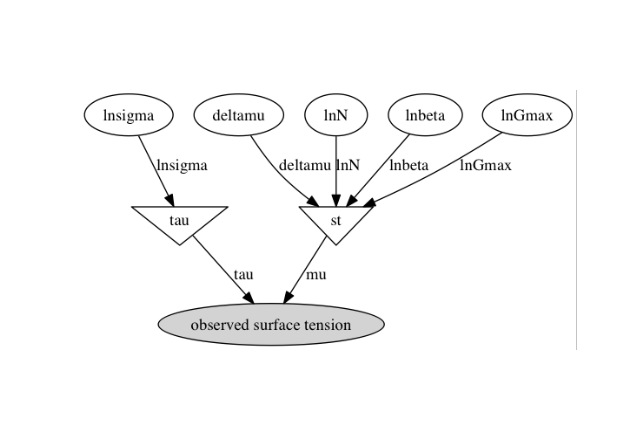

(-0.5, 571.5, 298.5, -0.5)

In [7]:
import matplotlib.image as mpimg
graph = pymc.graph.dag(model)
graph.write_png('model.png')
img=mpimg.imread('model.png')
fig = plt.figure()
plt.imshow(img)
plt.axis('off')

## 4b. pymc Normal Approximation

Estimate local likelihood as normally distributed. This computes variance estimates that are useful to get the MCMC running efficiently.

In [8]:
NA = pymc.NormApprox(model)
NA.fit()

## 5. Run inference
This runs a MCMC simulation to sample the posterior distributions of the parameters. The initial point if the maximum likelihood parameters, and the `scales` keyword to the adaptive Netropolis step method gets passed a dictionary containing the local variance estimates from the pymc normal approximation just above. MCMC is performed using the statistical model defined above.

Parameters to tweak:
- Number of steps for the MCMC chain to take, keyword `iter`
- Number of steps to throw out from the beginning of the chain, keyword `burn`
- Number of presumably autocorrelated steps to skip between recording samples, keyword `thin`

In [9]:
M = pymc.MCMC(model)
M.use_step_method(pymc.AdaptiveMetropolis, delay=1000, interval=100,
                  scales={lnGmax:  np.array(NA.C[lnGmax])[0][0],
                          lnsigma: np.array(NA.C[lnsigma])[0][0],
                          deltamu: np.array(NA.C[deltamu])[0][0],
                          lnbeta:  np.array(NA.C[lnbeta])[0][0],
                          lnN:     np.array(NA.C[lnN])[0][0]},
                  stochastic=[lnGmax, lnsigma, deltamu, lnbeta, lnN])

M.sample(iter=100000, burn=5000, thin=10)

 [-----------------100%-----------------] 100000 of 100000 complete in 232.4 sec

## 6. Plot MCMC traces, pairwise correlations, and posterior distributions

<IPython.core.display.Javascript object>


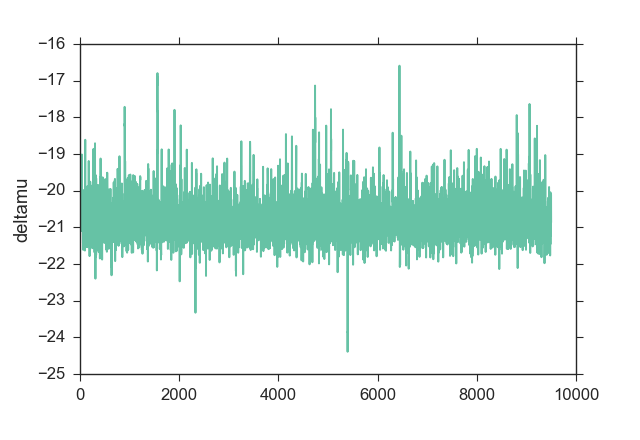

<IPython.core.display.Javascript object>


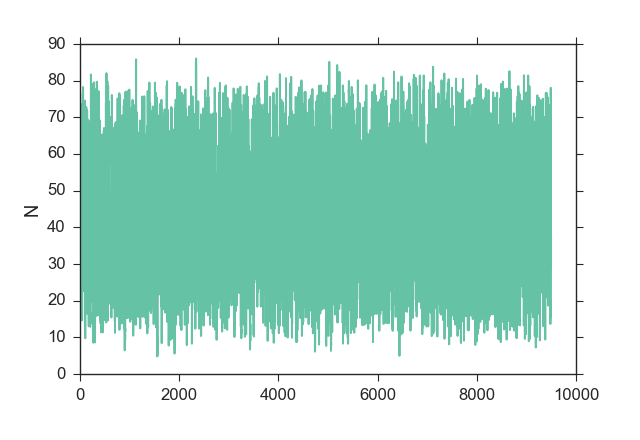

<IPython.core.display.Javascript object>


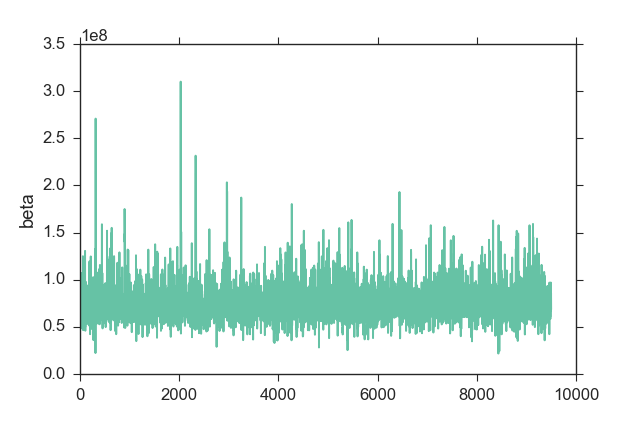

<IPython.core.display.Javascript object>


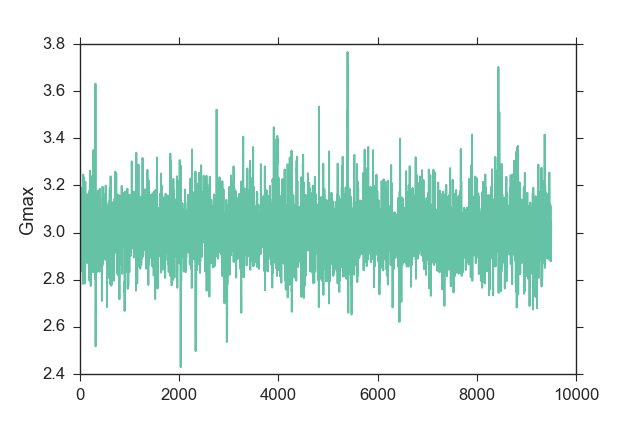

<IPython.core.display.Javascript object>


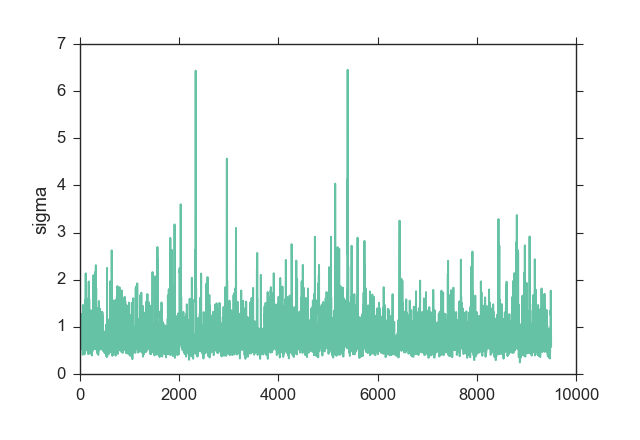

<IPython.core.display.Javascript object>


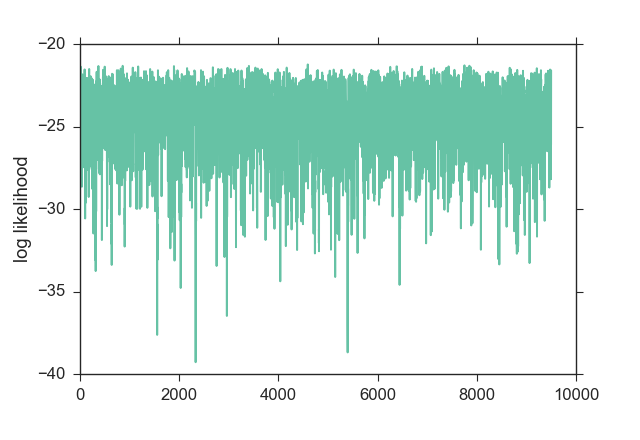

In [10]:
deltamu_trace = M.trace('deltamu')[:]
N_trace = np.exp(M.trace('lnN')[:])
beta_trace = np.exp(M.trace('lnbeta')[:])
Gmax_trace = np.exp(M.trace('lnGmax')[:])
sigma_trace = np.exp(M.trace('lnsigma')[:])

def logp_trace(model):
    """
    return a trace of logp for model
    """

    #init
    db = model.db
    n_samples = db.trace('deviance').length()
    logp = np.empty(n_samples, np.double)

    #loop over all samples
    for i_sample in xrange(n_samples):
        #set the value of all stochastic to their 'i_sample' value
        for stochastic in model.stochastics:
            try:
                value = db.trace(stochastic.__name__)[i_sample]
                stochastic.value = value

            except KeyError:
                print "No trace available for %s. " % stochastic.__name__

        #get logp
        logp[i_sample] = model.logp

    return logp

lnL_trace = logp_trace(M)

fig = plt.figure()
plt.plot(deltamu_trace)
plt.ylabel('deltamu')
plt.gcf().subplots_adjust(bottom=0.15)
fig = plt.figure()
plt.plot(N_trace)
plt.ylabel('N')
plt.gcf().subplots_adjust(bottom=0.15)
fig = plt.figure()
plt.plot(beta_trace)
plt.ylabel('beta')
plt.gcf().subplots_adjust(bottom=0.15)
fig = plt.figure()
plt.plot(Gmax_trace)
plt.ylabel('Gmax')
plt.gcf().subplots_adjust(bottom=0.15)
fig = plt.figure()
plt.plot(sigma_trace)
plt.ylabel('sigma')
plt.gcf().subplots_adjust(bottom=0.15)
fig = plt.figure()
plt.plot(lnL_trace)
plt.ylabel('log likelihood')
plt.gcf().subplots_adjust(bottom=0.15)

### 6b. Plot pairwise correlations and posterior distributions

Pairwise correlations are shown by plots of all recorded points from the MCMC trace. Points are colored by likelihood, with yellow the most likely and purple the least likely.

**Note:** The distributions below do not represent physical distributions. For example, the `N` distribution does not represent an actual micelle size distribution. It is a posterior distribution representing our knowledge of the `N` parameter for the STAND model, in which there is a single micelle size.

<IPython.core.display.Javascript object>


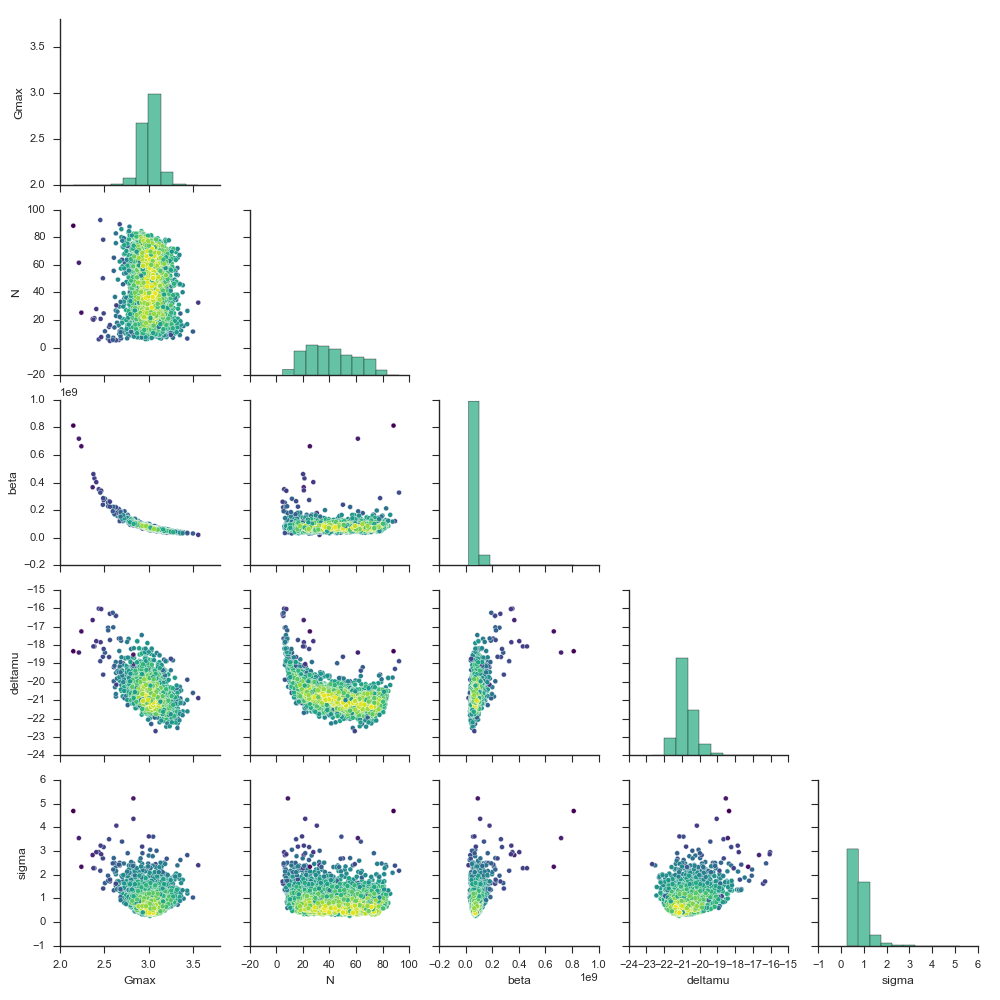

In [15]:
sns.set(style='ticks', palette='Set2', font_scale=1.)
g = sns.pairplot(pd.DataFrame({'beta':beta_trace,
                               'Gmax':Gmax_trace,
                               'N':N_trace,
                               'deltamu':deltamu_trace,
                               'sigma':sigma_trace}),
                plot_kws={'c':lnL_trace, 'cmap':cm.viridis})
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

## 7. Plot posterior predictive distribution

This plots the median prediction and shades between the 2.5th and 97.5th percentile predictions. Assuming zero discrepancy, 95% of experimental observations should fall in the shaded region.

Check for (systematic) discrepancy. If sigma (above) is much bigger than expected, or if it doesn't appear that 95% of experimental data is falling within the bounds, then there is systematic discrepancy.

<IPython.core.display.Javascript object>


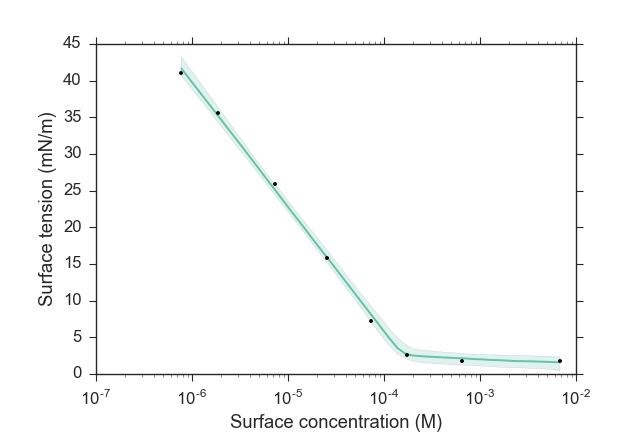

In [16]:
sns.set(style='ticks', palette='Set2', font_scale=1.5)

fig = plt.figure()
st_result = []
ct_sample = np.logspace(np.log10(min(ct_data)), np.log10(max(ct_data)))
for deltamu_sample, N_sample, beta_sample, Gmax_sample in zip(deltamu_trace,
                                                              N_trace,
                                                              beta_trace,
                                                              Gmax_trace)[::100]:
    cf_sample = cf_from_ct(ct_sample, deltamu_sample, N_sample)
    st_result.append(72.-pressure_from_cf(cf_sample, beta_sample, Gmax_sample, T))
st_result = np.array(st_result)
st_95 = np.percentile(st_result, 97.5, axis=0)
st_50 = np.percentile(st_result, 50, axis=0)
st_5 = np.percentile(st_result, 2.5, axis=0)

plt.fill_between(ct_sample, st_5, st_95, alpha=0.2)
plt.plot(ct_sample, st_50)
plt.plot(ct_data, st_data, 'k.')
plt.xlabel('Surface concentration (M)')
plt.ylabel('Surface tension (mN/m)')
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)

plt.xscale('log')